In [ ]:
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from utilsMW.dataLoaderMW import TorchDatasetMWToy
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback

from searchTest.toyEnvironment import check_outpt
from torch.utils.data import DataLoader



In [ ]:
class asdasd(torch.utils.data.Dataset):
    def __init__(self, asd):
        print('init')
        self.data = torch.arange(10)
        print(len(self.data))

    def __len__(self):
        'Denotes the total number of samples'
        print(len(self.data))
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.data[index]

In [ ]:
path = '/home/hendrik/Documents/master_project/LokalData/metaworld/pick-place/training_data/'
device = 'cuda'
batch_size = 2
#train_data = TorchDatasetMW(path=path, device=device)
train_data = asdasd(asd=1)
train_indices = torch.randperm(int(len(train_data)))
train_indices = train_indices[:int(len(train_indices)*1)]
print(len(train_data))
train_data = torch.utils.data.Subset(train_data, [0])
print(f'len(train_data): {len(train_data)}')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
path_train = '/home/hendrik/Documents/master_project/LokalData/metaworld/small/train/'
path_validate = '/home/hendrik/Documents/master_project/LokalData/metaworld/small/val/'
train_data = TorchDatasetMWToy(path=path_train, device='cpu')
val_data = TorchDatasetMWToy(path=path_validate, device='cpu')
print(train_data.data.shape)
print(train_data.label.shape)

In [ ]:
train_data.data.size(0)

In [ ]:
import stable_baselines3

In [ ]:
global SAMPLED_ENVS
global STEPS_TAKEN
SAMPLED_ENVS = 0
STEPS_TAKEN = 0

In [ ]:
class my_env():
    def __init__(self, train_data):
        #obs = step, data, action, current_env
        self.observation_space = gym.spaces.box.Box(np.array([0, -2,-2,-2,-2, 0,0,0,0.,0]), np.array([6, 2,2,2,2, 1,1,1,1.,train_data.data.size(0)]), (10,), float)
        #next state (4)
        self.action_space = gym.spaces.box.Box(np.array([0,0,0,0]), np.array([1,1,1,1]), (4,), float)
        self.metadata = {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
        self.steps = 0
        self.current_env = -1
        self.data = train_data.data
        self.label = train_data.label
        self.traj = None
        self.num_envs = 1
    def reset(self):
        global SAMPLED_ENVS
        global STEPS_TAKEN
        STEPS_TAKEN += 1
        SAMPLED_ENVS += 1
        self.traj = None
        self.current_env = (self.current_env + 1)%len(self.data)
        self.steps = 0
        last_action = torch.zeros(4, dtype=float, device=self.data.device)
        step = torch.tensor(self.steps, device=self.data.device)
        current_env = torch.tensor(self.current_env, device=self.data.device)
        data = self.data[self.current_env, 0]
        #label = self.label[self.current_env,0]
        state = torch.cat((step.view(1), data, last_action, current_env.view(1)), dim=0).numpy()
        #print(f'reset: {state.shape}')
        return state

    def step(self, action):
        global STEPS_TAKEN
        STEPS_TAKEN += 1
        if type(action) is np.ndarray:
            action = torch.tensor(action, device=self.data.device)
        if self.traj is None:
            self.traj = action.reshape(1,-1)
        else:
            self.traj = torch.cat((self.traj, action.reshape(1,-1)), dim=0)



        self.steps += 1
        step = torch.tensor(self.steps, device=self.data.device)
        current_env = torch.tensor(self.current_env, device=self.data.device)

        #label = self.label[self.current_env, self.current_step]
        data = self.data[self.current_env, 0]

        state = torch.cat((step.view(1), data, action.reshape(-1), current_env.view(1)), dim=0).numpy()
        #print(f'step: {state.shape}')

        if self.steps >= self.label.size(1):
            tol_neg = -0.55*torch.ones([self.traj.size(-1)])
            tol_pos = 0.7*torch.ones([self.traj.size(-1)])
            reward = int(check_outpt(self.label[self.current_env].unsqueeze(0), self.traj.unsqueeze(0), tol_neg=tol_neg, tol_pos=tol_pos))
            return (state, reward, True, {})
        else:
            return (state, 0., False, {})

    def close(self):
        pass
    
    def render(self, mode):
        pass

class toy_exper_model(OnPolicyAlgorithm):
    def __init__(
            self,
            policy: Union[str, Type[ActorCriticPolicy]] = 'MlpPolicy',
            env: Union[GymEnv, str] = None,
            learning_rate = 3e-4,
            n_steps: int = 2048,
            batch_size: int = 64,
            n_epochs: int = 10,
            gamma: float = 0.99,
            gae_lambda: float = 0.95,
            clip_range = 0.2,
            clip_range_vf = None,
            normalize_advantage: bool = True,
            ent_coef: float = 0.0,
            vf_coef: float = 0.5,
            max_grad_norm: float = 0.5,
            use_sde: bool = False,
            sde_sample_freq: int = -1,
            target_kl: Optional[float] = None,
            tensorboard_log: Optional[str] = None,
            create_eval_env: bool = False,
            policy_kwargs: Optional[Dict[str, Any]] = None,
            verbose: int = 0,
            seed: Optional[int] = None,
            device: Union[th.device, str] = "auto",
            _init_setup_model: bool = True,
            train_data = None
        ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            create_eval_env=create_eval_env,
            seed=seed,
            _init_setup_model=False,
        )
        self.data = train_data.data
        self.label = train_data.label
        #obs = step, data, action, current_env
        self.observation_space = gym.spaces.box.Box(np.array([0, -2,-2,-2,-2, 0,0,0,0,0]), np.array([6, 2,2,2,2, 1,1,1,1,train_data.data.size(0)]), (10,), float)
        #next state (4)
        self.action_space = gym.spaces.box.Box(np.array([0,0,0,0]), np.array([1,1,1,1]), (4,), float)

    def predict(self, obs, state=None, episode_start=None, deterministic=False):
        step = int(obs.reshape(-1)[0])
        env = int(obs.reshape(-1)[-1])
        #print(f'expert: {self.label[env, step].reshape(1, -1).shape}')
        return self.label[env, step].reshape(1, -1), self.label[env, step].reshape(1, -1)


In [ ]:
train_data.data.shape

In [ ]:
toy_env = my_env(train_data=train_data)
val_env = my_env(train_data=val_data)
my_expert = toy_exper_model(train_data=train_data, env=toy_env)

In [ ]:
SAMPLED_ENVS = 0

In [ ]:
def sample_expert_transitions():
    expert = my_expert

    print("Sampling expert transitions.")
    rollouts = rollout.generate_trajectories(
        expert,
        DummyVecEnv([lambda: RolloutInfoWrapper(toy_env)]),
        rollout.make_sample_until(n_episodes=1000, n_timesteps=None),
    )
    return rollout.flatten_trajectories(rollouts)

In [ ]:
transitions = sample_expert_transitions()

In [ ]:
SAMPLED_ENVS = 0

In [ ]:
len(transitions)

In [ ]:
# @author Simon Stepputtis <sstepput@asu.edu>, Interactive Robotics Lab, Arizona State University

from pickle import NONE
from urllib.parse import non_hierarchical
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from hashids import Hashids
import os



class TBoardGraphsTorch():
    def __init__(self, logname= None, data_path = None, prefix = ''):
        if logname is not None:
            self.__hashids           = Hashids()
            #self.logdir              = "Data/TBoardLog/" + logname + "/"
            self.logdir              = os.path.join(data_path, "gboard/" + logname + "/")
            print(f'log dir: {self.logdir + "train/"}')
            self.__tboard_train      = tf.summary.create_file_writer(self.logdir + prefix + "train/")
            self.__tboard_validation = tf.summary.create_file_writer(self.logdir + prefix + "validate/")
            #self.voice               = Voice(path=data_path)
        self.fig, self.ax = plt.subplots(3,3)

    def startDebugger(self):
        tf.summary.trace_on(graph=True, profiler=True)
    
    def stopDebugger(self):
        with self.__tboard_validation.as_default():
            tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=self.logdir)

    def finishFigure(self, fig):
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return data
    
    def addTrainScalar(self, name, value, stepid):
        with self.__tboard_train.as_default():
            tfvalue = self.torch2tf(value)
            tf.summary.scalar(name, tfvalue, step=stepid)

    def addValidationScalar(self, name, value, stepid):
        with self.__tboard_validation.as_default():
            tfvalue = self.torch2tf(value)
            tf.summary.scalar(name, tfvalue, step=stepid)

    def torch2tf(self, inpt):
        if inpt is not None:
            return tf.convert_to_tensor(inpt.detach().cpu().numpy())
        else:
            return inpt

    def plotTrajectory(self, y_true, y_pred, dt_true, dt_pred, stepid):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)
        tf_dt_true = self.torch2tf(dt_true)
        tf_dt_pred = self.torch2tf(dt_pred)

        fig, ax = plt.subplots(3,3)
        fig.set_size_inches(9, 9)

        tf_dt_true = 1.0/tf_dt_true.numpy()
        tf_dt_pred = 1.0/tf_dt_pred.numpy()[0]

        max_trj_len = tf_y_true.shape[0]
        for sp in range(7):
            idx = sp // 3
            idy = sp  % 3
            ax[idx,idy].clear()
            ax[idx,idy].plot(range(max_trj_len), tf_y_pred[:,sp], alpha=0.5, color='midnightblue')
            ax[idx,idy].plot(range(max_trj_len), tf_y_true[:,sp], alpha=0.5, color='forestgreen')
            # ax[idx,idy].plot([dt_pred, dt_pred], [-0.1, 1.1], alpha=0.5, linestyle=":", color="midnightblue")
            # ax[idx,idy].plot([dt_true, dt_true], [-0.1, 1.1], alpha=0.5, linestyle=":", color="forestgreen")
            # ax[idx,idy].set_ylim([-0.1, 1.1])

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Trajectory", data=result, step=stepid)

    def idToText(self, id):
        names = ["", "ysr", "rsr", "gsr", "bsr", "psr", "ylr", "rlr", "glr", "blr", "plr", "yss", "rss", "gss", "bss", "pss", "yls", "rls", "gls", "bls", "pls"]
        return names[id]

    def plotAttention(self, attention_weights, image_dict, language, stepid):
        tf_attention_weights = self.torch2tf(attention_weights)
        tf_language = self.torch2tf(language)

        tf_attention_weights = tf_attention_weights.numpy()
        classes           = image_dict["detection_classes"][0][:len(tf_attention_weights)].numpy().astype(dtype=np.int32)
        classes           = [self.idToText(i) for i in classes]
        x                 = np.arange(len(tf_attention_weights))
        
        fig, ax = plt.subplots()
        plt.bar(x, tf_attention_weights)
        plt.xticks(x, classes)
        ax.set_ylim([0, 1])
        plt.text(0.01, 0.95, self.voice.tokensToSentence(tf_language.numpy().tolist()), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Attention", data=result, step=stepid)
    
    def plotClassAccuracy(self, gt_class, pred_class, pred_class_std, language, stepid):
        labels     = ["ysr", "rsr", "gsr", "bsr", "psr", "ylr", "rlr", "glr", "blr", "plr", "yss", "rss", "gss", "bss", "pss", "yls", "rls", "gls", "bls", "pls"]
        tf_gt_class = self.torch2tf(gt_class)
        tf_pred_class = self.torch2tf(pred_class)
        tf_language = self.torch2tf(language)

        
        
        tf_gt_class   = tf_gt_class.numpy()
        tf_pred_class = tf_pred_class.numpy()
        x          = np.arange(len(tf_gt_class))
        width      = 0.35
        
        fig, ax = plt.subplots()
        #rects1 = ax.bar(x - width/2, gt_class, width, label='GT', color="forestgreen")
        #rects2 = ax.bar(x + width/2, pred_class, width, yerr=pred_class_std, label='Pred', color="midnightblue")
        ax.set_xticks(x)
        # ax.set_xticklabels(labels)
        plt.text(0.01, 0.95, self.voice.tokensToSentence(tf_language.numpy().tolist()), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Attention", data=result, step=stepid)

    def plotDeltaT(self, y_true, y_pred, stepid):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)

        gt = tf_y_true.numpy()
        pd = tf_y_pred.numpy()[:,0]
        jdata = np.stack((gt,pd), axis=1)
        svals = jdata[np.argsort(jdata[:,0]),:]
        x     = np.arange(svals.shape[0])
        width = 0.35
        
        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, svals[:,0], width, label='GT', color="forestgreen")
        rects2 = ax.bar(x + width/2, svals[:,1], width, label='Pred', color="midnightblue")
        ax.set_xticks(x)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("DeltaT", data=result, step=stepid)

    def plotWeights(self, gt_w, pred_w, stepid):
        tf_gt_w = self.torch2tf(gt_w)
        tf_pred_w = self.torch2tf(pred_w)

        fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,sharex=True)
        # fig.set_size_inches(4, 10)

        combined_weights = np.concatenate((tf_gt_w.numpy(), tf_pred_w.numpy()), axis=0).T

        ax1.imshow(combined_weights[:,:7], cmap="RdBu")
        ax2.imshow(combined_weights[:,7:], cmap="RdBu")

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Weights", data=result, step=stepid)

    def interpolateTrajectory(self, trj, target):
        tf_trj = self.torch2tf(trj)
        tf_target = self.torch2tf(target)

        current_length = tf_trj.shape[0]
        dimensions     = tf_trj.shape[1]
        result         = np.zeros((tf_target, dimensions), dtype=np.float32)
    
        for i in range(dimensions):
            result[:,i] = np.interp(np.linspace(0.0, 1.0, num=tf_target), np.linspace(0.0, 1.0, num=current_length), trj[:,i])
        
        return result

    def plotDMPTrajectory(self, y_true, y_pred, y_pred_std = None, phase= None, \
        dt= None, p_dt= None, stepid= None, name = "Trajectory", save = False, \
            name_plot = None, path=None, tol_neg = None, tol_pos=None, inpt = None, opt_gen_trj=None, window = 0):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)
        tf_phase = self.torch2tf(phase)
        tf_inpt = self.torch2tf(inpt)
        if p_dt is not None:
            tf_dt = self.torch2tf(dt)
            tf_p_dt = self.torch2tf(p_dt)
        if opt_gen_trj is not None:
            tf_opt_gen_trj = self.torch2tf(opt_gen_trj)
            tf_opt_gen_trj = tf_opt_gen_trj.numpy()

        tf_y_true      = tf_y_true.numpy()
        tf_y_pred      = tf_y_pred.numpy()
        tf_inpt        = tf_inpt.numpy()
        if tf_phase is not None:
            tf_phase       = tf_phase.numpy()

        if p_dt is not None:
            tf_dt          = tf_dt.numpy() * 350.0
            tf_p_dt        = tf_p_dt.numpy()
        trj_len      = tf_y_true.shape[0]
        
        #fig, ax = plt.subplots(3,3)
        fig, ax = self.fig, self.ax
        #fig.set_size_inches(9, 9)
        neg_inpt = tf_y_true + tol_neg[None,:].cpu().numpy()
        pos_inpt = tf_y_true + tol_pos[None,:].cpu().numpy()
        for sp in range(len(tf_y_true[0])):
            idx = sp // 3
            idy = sp  % 3
            ax[idx,idy].clear()

            # GT Trajectory:
            if tol_neg is not None:

                ax[idx,idy].plot(range(tf_y_pred.shape[0]), neg_inpt[:,sp], alpha=0.75, color='orangered')
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), pos_inpt[:,sp], alpha=0.75, color='orangered')
            ax[idx,idy].plot(range(trj_len), tf_y_true[:,sp],   alpha=1.0, color='forestgreen')            
            ax[idx,idy].plot(range(tf_y_pred.shape[0]), tf_y_pred[:,sp], alpha=0.75, color='mediumslateblue')
            if opt_gen_trj is not None:
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), tf_opt_gen_trj[:,sp], alpha=0.75, color='lightseagreen')
                diff_vec = tf_opt_gen_trj - tf_y_pred
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), diff_vec[:,sp], alpha=0.75, color='pink')

            #ax[idx,idy].errorbar(range(tf_y_pred.shape[0]), tf_y_pred[:,sp], xerr=None, yerr=None, alpha=0.25, fmt='none', color='mediumslateblue')
            #ax[idx,idy].set_ylim([-0.1, 1.1])
            if p_dt is not None:
                ax[idx,idy].plot([tf_dt, tf_dt], [0.0,1.0], linestyle=":", color='forestgreen')

        if inpt is not None:
            ax[-1,-1].clear()
            ax[-1,-1].plot(range(inpt.shape[-1]), tf_inpt,   alpha=1.0, color='forestgreen')     
        
        if tf_phase is not None:
            ax[2,2].clear()
            ax[2,2].plot(range(tf_y_pred.shape[0]), tf_phase, color='orange')
        if p_dt is not None:
            ax[2,2].plot([tf_dt, tf_dt], [0.0,1.0], linestyle=":", color='forestgreen')
            ax[2,2].plot([tf_p_dt*350.0, tf_p_dt*350.0], [0.0,1.0], linestyle=":", color='mediumslateblue')
            ax[2,2].set_ylim([-0.1, 1.1])

        result = np.expand_dims(self.finishFigure(fig), 0)
        if save:
            if not os.path.exists(path):
                os.makedirs(path)
            plt.savefig(path + name_plot + '.png')
        #fig.clear()
        #plt.close()
        if not save:
            with self.__tboard_validation.as_default():
                tf.summary.image(name, data=result, step=stepid)

log dir: /home/hendrik/Documents/master_project/LokalData/test/gboard/BC_PPO/train/


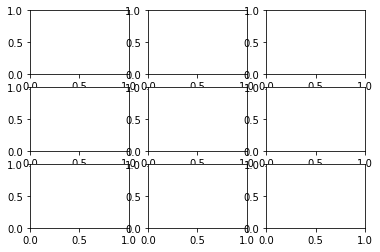

In [22]:
from hashids import Hashids
import tensorflow as tf
import matplotlib.pyplot as plt
tboard = TBoardGraphsTorch(logname='BC_PPO', data_path='/home/hendrik/Documents/master_project/LokalData/test/', prefix='BC ')

In [33]:
bc_trainer = bc.BC(
    observation_space=toy_env.observation_space,
    action_space=toy_env.action_space,
    expert_data=transitions,
    optimizer_kwargs={'lr':1e-4}
)
torch.save(bc_trainer.policy.state_dict(), "/home/hendrik/Documents/master_project/LokalData/test/bc0.8")
bc_trainer.policy.load_state_dict(torch.load("/home/hendrik/Documents/master_project/LokalData/test/bc0.8"))

<All keys matched successfully>

In [34]:
tboard = TBoardGraphsTorch(logname='BC_PPO_1e-4', data_path='/home/hendrik/Documents/master_project/LokalData/test/')
for i in range(100):
    rew = []
    for j in range(1000):
        obs = val_env.reset()
        done = False
        while not done:
            action, _ = bc_trainer.policy.predict(obs)
            obs, reward, done, _ = val_env.step(action=action)
        rew.append(reward)
    reward = torch.tensor(rew).type(torch.float).mean()
    print(reward)
    tboard.addValidationScalar('success rate', reward.detach(), stepid=i)
    target_trj = val_env.label[val_env.current_env]
    gen_trj = val_env.traj
    inpt = val_env.data[val_env.current_env][0]

    tol_neg = -0.55*torch.ones([val_env.traj.size(-1)])
    tol_pos = 0.7*torch.ones([val_env.traj.size(-1)])
    tboard.plotDMPTrajectory(target_trj, gen_trj, torch.zeros_like(gen_trj),
                                None, None, None, stepid=i, save=False, name_plot='imitation baseline', path='',\
                                    tol_neg=tol_neg, tol_pos=tol_pos, inpt = inpt, name='imitation baseline', opt_gen_trj = None, window=None)
    bc_trainer.train(n_epochs=20, log_interval=100000000)


log dir: /home/hendrik/Documents/master_project/LokalData/test/gboard/BC_PPO_1e-4/train/


/home/hendrik/anaconda3/envs/sb/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


tensor(0.)


BC epoch: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


tensor(0.0050)


BC epoch: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


tensor(0.0150)


BC epoch: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


tensor(0.0270)


BC epoch:  65%|██████▌   | 13/20 [00:12<00:04,  1.57it/s]

In [ ]:
from stable_baselines3.common.env_util import make_vec_env
vec_toy_env = make_vec_env(my_env, n_envs=1)
SAMPLED_ENVS = 0
STEPS_TAKEN = 0

In [ ]:
import copy

In [ ]:
policy.save('backup')


In [ ]:
policy.load('backup')


In [ ]:
SAMPLED_ENVS = 0
STEPS_TAKEN = 0
rein_model = PPO("MlpPolicy", vec_toy_env, verbose=0, learning_rate=1e-4)
rein_model.policy = policy
rein_model.policy.to(rein_model.device)

for i in range(100):
    rein_model.learn(total_timesteps=1000)
    print_reward(rein_model.policy)

In [ ]:
SAMPLED_ENVS

In [ ]:
STEPS_TAKEN

In [ ]:
def print_reward(policy, logname = 'ppo'):
    tboard = TBoardGraphsTorch(logname=logname, data_path='/home/hendrik/Documents/master_project/LokalData/stableBaselines/')
    rew = []
    for j in range(1000):
        obs = val_env.reset()
        done = False
        while not done:
            action, _ = policy.predict(obs)
            obs, reward, done, _ = val_env.step(action=action)
        rew.append(reward)
    reward = torch.tensor(rew).type(torch.float).mean()
    print(f'num_envs: {SAMPLED_ENVS}')
    print(reward)
    tboard.addValidationScalar('success rate', reward.detach(), stepid=i)
    target_trj = val_env.label[val_env.current_env]
    gen_trj = val_env.traj
    inpt = val_env.data[val_env.current_env][0]

    tol_neg = -0.55*torch.ones([val_env.traj.size(-1)])
    tol_pos = 0.7*torch.ones([val_env.traj.size(-1)])
    tboard.plotDMPTrajectory(target_trj, gen_trj, torch.zeros_like(gen_trj),
                                None, None, None, stepid=i, save=False, name_plot='ppo fine tuning baseline', path='',\
                                    tol_neg=tol_neg, tol_pos=tol_pos, inpt = inpt, name='ppo fine tuning baseline', opt_gen_trj = None, window=None)


In [ ]:
for i in range(100):
    rew = []
    for j in range(1000):
        obs = val_env.reset()
        done = False
        while not done:
            action, _ = bc_trainer.policy.predict(obs)
            obs, reward, done, _ = val_env.step(action=action)
        rew.append(reward)
    reward = torch.tensor(rew).type(torch.float).mean()
    print(reward)
    tboard.addValidationScalar('success rate', reward.detach(), stepid=SAMPLED_ENVS)
    target_trj = val_env.label[val_env.current_env]
    gen_trj = val_env.traj
    inpt = val_env.data[val_env.current_env][0]

    tol_neg = -0.55*torch.ones([val_env.traj.size(-1)])
    tol_pos = 0.7*torch.ones([val_env.traj.size(-1)])
    tboard.plotDMPTrajectory(target_trj, gen_trj, torch.zeros_like(gen_trj),
                                None, None, None, stepid=i, save=False, name_plot='imitation baseline', path='',\
                                    tol_neg=tol_neg, tol_pos=tol_pos, inpt = inpt, name='imitation baseline', opt_gen_trj = None, window=None)
    bc_trainer.train(n_epochs=5)